## Exploring the NDVI in Philadelphia

In this part, I explore the NDVI in Philadelphia a bit more. This part will include two parts:

1. Compare the median NDVI within the city limits and the immediate suburbs
1. Calculate the  NDVI around street trees in the city.

## 1. Comparing the NDVI in the city and the suburbs

### 1.1 Load Landsat data for Philadelphia

Use rasterio to load the landsat data for Philadelphia

In [1]:
import rasterio as rio
import geopandas as gpd
landsat = rio.open("./data/landsat8_philly.tif")

### 1.2 Separating the city from the suburbs

Create two polygon objects, one for the city limits and one for the suburbs. To calculate the suburbs polygon, we will take everything outside the city limits but still within the bounding box. 

In [2]:
city_limits = gpd.read_file("./data/City_Limits.geojson")
city_limits = city_limits.to_crs(landsat.crs.data['init'])

### 1.3 Mask and calculate the NDVI for the city and the suburbs

Using the two polygons from the last section, use rasterio's mask functionality to create two masked arrays from the landsat data, one for the city and one for the suburbs. 

For each masked array, calculate the NDVI.

In [3]:
landsat_extent=[  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ]
suburb=city_limits.envelope.difference(city_limits.geometry)

In [4]:
from rasterio.mask import mask
masked_city, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

In [5]:
masked_suburb, mask_transform = mask(
    dataset=landsat,
    shapes=suburb.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

In [6]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """
    
    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)
    
    # Get valid entries
    check = np.logical_and( red.mask == False, nir.mask == False )
    
    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check,  (nir - red ) / ( nir + red ), np.nan )
    return ndvi 

In [7]:
import numpy as np
red_city = masked_city[3]
nir_city = masked_city[4]
NDVI_city = calculate_NDVI(nir_city, red_city)
red_suburb = masked_suburb[3]
nir_suburb = masked_suburb[4]
NDVI_suburb = calculate_NDVI(nir_suburb, red_suburb)

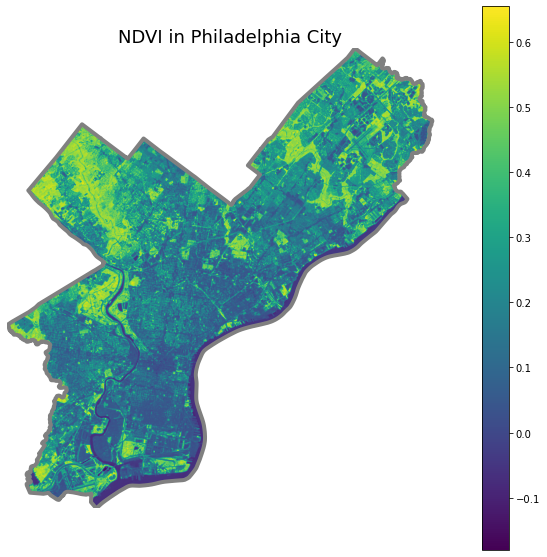

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

# Plot NDVI
img = ax.imshow(NDVI_city, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia City", fontsize=18);

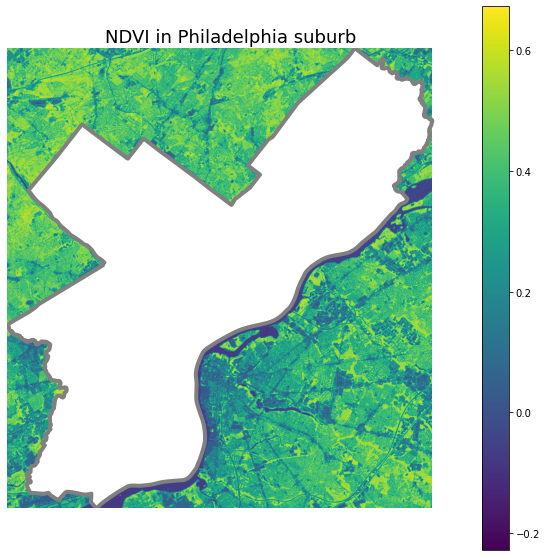

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot NDVI
img = ax.imshow(NDVI_suburb, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia suburb", fontsize=18);

### 1.4 Calculate the median NDVI within the city and within the suburbs

* Calculate the median value from your NDVI arrays for the city and suburbs
* Numpy's `nanmedian` function will be useful for ignoring NaN elements
* Print out the median values. Which has a higher NDVI: the city or suburbs?

In [10]:
from rasterstats import zonal_stats
stats_city = zonal_stats(city_limits, NDVI_city, affine=landsat.transform, stats=['median'])
stats_city

C:\Users\zheng\anaconda3\envs\musa-550-fall-2021\lib\site-packages\rasterstats\io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'median': 0.20246571107834677}]

In [11]:
stats_suburb= zonal_stats(suburb, NDVI_suburb, affine=landsat.transform, stats=['median'])
stats_suburb

C:\Users\zheng\anaconda3\envs\musa-550-fall-2021\lib\site-packages\rasterstats\io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'median': 0.3748493370831659}]

## 2. Calculating the NDVI for Philadelphia's street treets

### 2.1 Load the street tree data

The data is available in the "data/" folder. It has been downloaded from [OpenDataPhilly](https://www.opendataphilly.org/dataset/ppr-tree-canopy). It contains the locations of abot 2,500 street trees in Philadelphia.

In [12]:
street_tree=gpd.read_file("./data/ppr_tree_canopy_points_2015.geojson")
street_tree = street_tree.to_crs(landsat.crs.data['init'])

### 2.2 Calculate the NDVI values at the locations of the street trees

* Use the rasterstats package to calculate the NDVI values at the locations of the street trees.
* Since these are point geometries, you can calculate either the median or the mean statistic (only one pixel will contain each point).

In [13]:
stats_tree = zonal_stats(street_tree, NDVI_city, affine=landsat.transform, stats=['mean', 'median'])
stats_tree 

C:\Users\zheng\anaconda3\envs\musa-550-fall-2021\lib\site-packages\rasterstats\io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'mean': 0.23533681765389083, 'median': 0.23533681765389083},
 {'mean': 0.26153510526124424, 'median': 0.26153510526124424},
 {'mean': 0.09676935199429665, 'median': 0.09676935199429665},
 {'mean': 0.07662965738028744, 'median': 0.07662965738028744},
 {'mean': 0.2679520805273978, 'median': 0.2679520805273978},
 {'mean': 0.07685867381111855, 'median': 0.07685867381111855},
 {'mean': 0.1051902048359772, 'median': 0.1051902048359772},
 {'mean': 0.09178423236514523, 'median': 0.09178423236514523},
 {'mean': 0.07616818902392995, 'median': 0.07616818902392995},
 {'mean': 0.10229947492304907, 'median': 0.10229947492304907},
 {'mean': 0.10229947492304907, 'median': 0.10229947492304907},
 {'mean': 0.10498730652690197, 'median': 0.10498730652690197},
 {'mean': 0.06877747029138857, 'median': 0.06877747029138857},
 {'mean': 0.06877747029138857, 'median': 0.06877747029138857},
 {'mean': 0.05285700379635939, 'median': 0.05285700379635939},
 {'mean': 0.10498730652690197, 'median': 0.1049873065269019

### 2.3 Plotting the results

Make two plots of the results:

1. A histogram of the NDVI values, using matplotlib's `hist` function. Include a vertical line that marks the NDVI = 0 threshold
1. A plot of the street tree points, colored by the NDVI value, using geopandas' `plot` function. Include the city limits boundary on your plot.

The figures should be clear and well-styled, with for example, labels for axes, legends, and clear color choices. 

In [14]:
street_tree['median_NDVI'] = [s['median'] for s in stats_tree]
street_tree.head()

,objectid,fcode,geometry,median_NDVI
0,1,3000,POINT (499541.269 4434698.265),0.235337
1,2,3000,POINT (488932.471 4424093.158),0.261535
2,3,3000,POINT (489039.214 4425985.827),0.096769
3,4,3000,POINT (488993.171 4426088.005),0.076630
4,5,3000,POINT (488943.113 4424599.478),0.267952


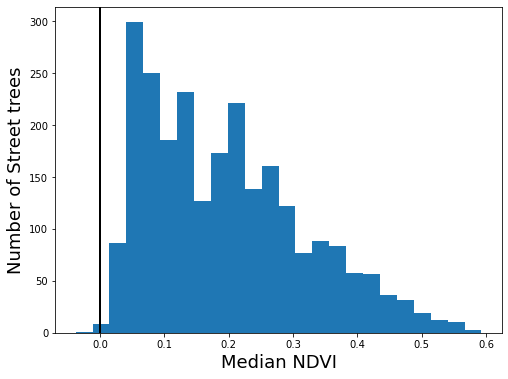

In [15]:
# Initialize
fig, ax = plt.subplots(figsize=(8,6))

# Plot a quick histogram 
ax.hist(street_tree['median_NDVI'], bins='auto')
ax.axvline(x=0, c='k', lw=2)

# Format
ax.set_xlabel("Median NDVI", fontsize=18)
ax.set_ylabel("Number of Street trees", fontsize=18);

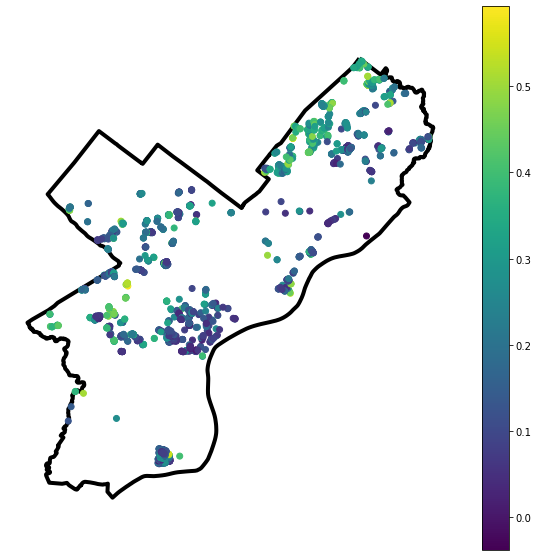

In [16]:
# Initialize
fig, ax = plt.subplots(figsize=(10,10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=4)

# Plot the median NDVI
street_tree.plot(column='median_NDVI', legend=True, ax=ax, cmap='viridis')

# Format
ax.set_axis_off()